In [2]:
from pymongo import MongoClient
import pandas as pd 
import re
from collections import Counter
from konlpy.tag import Okt
from mecab import MeCab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # word embedding

# ÎÑ§Ìä∏ÏõåÌÅ¨ Ïó∞Í≤∞ Í∑úÏπô : protocol://ip:port/path 
client = MongoClient('mongodb://192.168.0.50:27017/')

db_name = client["DB_SGMN"]
collection = db_name["COL_SCRAPPING_TOSS_COMMENT_HISTORY"]

In [3]:
find_data = collection.find()
data_list = list(find_data)

In [4]:
df_data = pd.DataFrame(data_list)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251836 entries, 0 to 251835
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   _id         251836 non-null  object        
 1   COMMENT     251836 non-null  object        
 2   CREATED_AT  251836 non-null  datetime64[ns]
 3   DATE        251836 non-null  object        
 4   DATETIME    251836 non-null  object        
 5   SYMBOL      251836 non-null  object        
 6   UPDATED_AT  251836 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 13.4+ MB


In [5]:
df_data[:50000].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   _id         50000 non-null  object        
 1   COMMENT     50000 non-null  object        
 2   CREATED_AT  50000 non-null  datetime64[ns]
 3   DATE        50000 non-null  object        
 4   DATETIME    50000 non-null  object        
 5   SYMBOL      50000 non-null  object        
 6   UPDATED_AT  50000 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 2.7+ MB


In [6]:
# df_data[:50000].to_csv('output.csv', index=False)  # index=FalseÎ°ú Ïù∏Îç±Ïä§ Ïó¥ Ï†úÏô∏

In [7]:
mecab_inst = MeCab()

In [8]:
# Ï£ºÏ∞® Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Ìï®Ïàò Ï†ïÏùò
def get_week(date_str):
    # Ï†ïÍ∑ú ÌëúÌòÑÏãùÏúºÎ°ú Ïó∞ÎèÑÏôÄ Ïõî, ÏùºÏùÑ Ï∂îÏ∂ú
    match = re.match(r'(\d{4})-(\d{2})-(\d{2})', date_str)
    if match:
        year, month, day = map(int, match.groups())
        # ÎÇ†Ïßú Í∞ùÏ≤¥ ÏÉùÏÑ±
        date = pd.Timestamp(year=year, month=month, day=day)
        # ISO Ï£ºÏ∞® Î∞òÌôò
        return date.isocalendar()[1]  # Ï£ºÏ∞®
    return None


In [16]:
# DATE Ïó¥ÏóêÏÑú Ï£ºÏ∞® Í≥ÑÏÇ∞
df_data['WEEK'] = df_data['DATE'].apply(get_week)
df_data['WEEK'].unique()
# # Ï£ºÏ∞®Î≥ÑÎ°ú Í∑∏Î£πÌôîÌïòÏó¨ ÏßëÍ≥Ñ (Ïòà: VALUEÏùò Ìï©Í≥Ñ)
# weekly_data = df_data.groupby(['WEEK']).agg({'COMMENT': ' '.join}).reset_index()

# # Í≤∞Í≥º Ï∂úÎ†•
# print(weekly_data)

array([47, 49, 50, 51, 52])

In [35]:
stopwords = ['Í±¥Í∞ÄÏöî','Í∞ÄÏ¶à']   
ngramrange = (1,3)

[(611.8202610047656, 'ÌÖåÏä¨Îùº'), (431.9746960001819, 'ÏóîÎπÑÎîîÏïÑ'), (364.76516068212453, 'Í∞ÄÏ¶à'), (359.84212288142095, 'Ïò§Îäò'), (264.727124583064, 'Îã¨Îü¨'), (257.65101779544386, 'Ï£ºÏãù'), (209.24963898363973, 'Í≥†Ï†ê'), (207.5542428964945, 'Ï∂îÎß§'), (184.41221439271467, 'Ïù¥Í±∞'), (179.34178702867183, 'ÏàòÏùµ')]


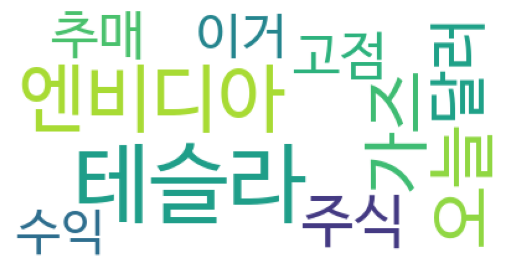

In [34]:
week = 49
df_week = df_data[df_data['WEEK'] == week]['COMMENT']
string_nouns = []
for text in df_week: 
    nouns_text = mecab_inst.nouns(text)
    filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]
    modify_nouns = [noun if noun != 'ÏóîÎπÑ' else 'ÏóîÎπÑÎîîÏïÑ' for noun in filtered_nouns]
    modify_nouns2 = [noun if noun != 'ÎπÑÎîîÏïÑ' else 'ÏóîÎπÑÎîîÏïÑ' for noun in modify_nouns]
    string_nouns.append(' '.join(modify_nouns2))  # join() Î©îÏÑúÎìú ÏÇ¨Ïö©
    
tfidfvectorizer = TfidfVectorizer(
    stop_words=stopwords, 
    ngram_range=ngramrange)
tfidfvectorizer.fit(string_nouns) # ÌïôÏäµ
result_vectors = tfidfvectorizer.transform(string_nouns) 
tfidf_scores = result_vectors.toarray().sum(axis=0)
tfidf_rank_10 = sorted(zip(tfidf_scores, tfidfvectorizer.get_feature_names_out()), reverse=True)[:10]
print(tfidf_rank_10)
counter_dict = { word : score for score, word in tfidf_rank_10}
wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
wordcloud_instance.generate_from_frequencies(counter_dict) 
plt.imshow(wordcloud_instance)
plt.axis('off')
plt.show()

In [25]:
result_vectors.toarray().shape, tfidfvectorizer.get_feature_names_out().shape


((323, 2065), (2065,))

In [26]:
tfidf_scores = result_vectors.toarray().sum(axis=0)

In [27]:
tfidf_rank_10 = sorted(zip(tfidf_scores, tfidfvectorizer.get_feature_names_out()), reverse=True)[:10]
tfidf_rank_10

[(7.871902050428228, 'Ïï†Ìîå'),
 (5.166077273038156, 'ÏïÑÏ≤ò'),
 (3.938504286246629, 'ÏßÑÏûÖ'),
 (3.3402095618421175, 'Ï∂îÎß§'),
 (3.3155756270146606, 'Ï°∞ÎπÑ'),
 (3.115684886588695, 'ÏàòÏùµ'),
 (3.0578077726424615, 'ÌèâÎã®'),
 (2.684816138267277, 'Îã¨Îü¨'),
 (2.6251594038632176, 'ÎπÑÏ§ë'),
 (2.623336723207134, 'Í≥µÎß§ÎèÑ')]

[(7.871902050428228, 'Ïï†Ìîå'), (5.166077273038156, 'ÏïÑÏ≤ò'), (3.938504286246629, 'ÏßÑÏûÖ'), (3.3402095618421175, 'Ï∂îÎß§'), (3.3155756270146606, 'Ï°∞ÎπÑ'), (3.115684886588695, 'ÏàòÏùµ'), (3.0578077726424615, 'ÌèâÎã®'), (2.684816138267277, 'Îã¨Îü¨'), (2.6251594038632176, 'ÎπÑÏ§ë'), (2.623336723207134, 'Í≥µÎß§ÎèÑ')]


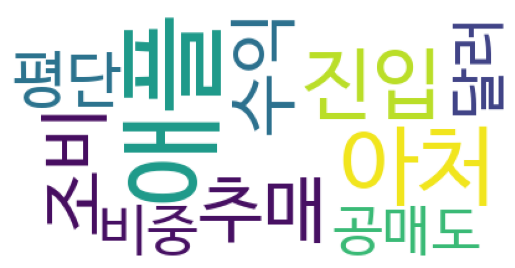

[(610.7769553569423, 'ÌÖåÏä¨Îùº'), (364.66808922299623, 'Í∞ÄÏ¶à'), (359.64015350196183, 'Ïò§Îäò'), (283.0475488444334, 'ÏóîÎπÑ'), (264.68983399707895, 'Îã¨Îü¨'), (257.2857945079452, 'Ï£ºÏãù'), (209.21147756349797, 'Í≥†Ï†ê'), (207.54046338317613, 'Ï∂îÎß§'), (184.4112718889778, 'Ïù¥Í±∞'), (179.094866711659, 'ÏàòÏùµ')]


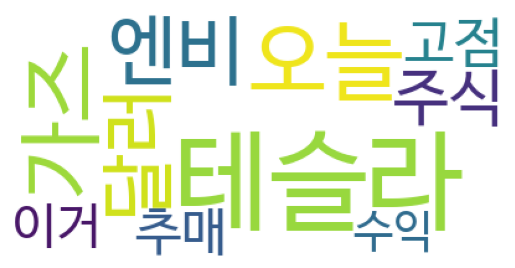

KeyboardInterrupt: 

In [29]:
for week in df_data['WEEK'].unique():
    df_week = df_data[df_data['WEEK'] == week]['COMMENT']
    string_nouns = []
    for text in df_week: 
        nouns_text = mecab_inst.nouns(text)
        filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]
        modify_nouns = [noun if noun != 'ÏóîÎπÑ' else 'ÏóîÎπÑÎîîÏïÑ' for noun in filtered_nouns]
        string_nouns.append(' '.join(filtered_nouns))  # join() Î©îÏÑúÎìú ÏÇ¨Ïö©
        
    tfidfvectorizer = TfidfVectorizer(
        stop_words=stopwords, 
        ngram_range=ngramrange)
    tfidfvectorizer.fit(string_nouns) # ÌïôÏäµ
    result_vectors = tfidfvectorizer.transform(string_nouns) 
    tfidf_scores = result_vectors.toarray().sum(axis=0)
    tfidf_rank_10 = sorted(zip(tfidf_scores, tfidfvectorizer.get_feature_names_out()), reverse=True)[:10]
    print(tfidf_rank_10)

    counter_dict = { word : score for score, word in tfidf_rank_10}

    wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
    wordcloud_instance.generate_from_frequencies(counter_dict) 

    plt.imshow(wordcloud_instance)
    plt.axis('off')
    plt.show()

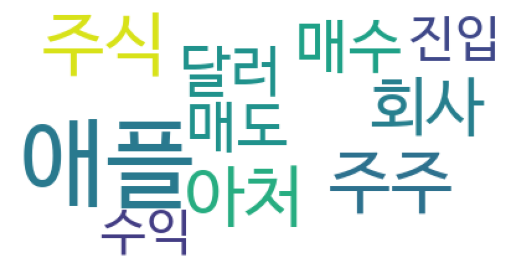

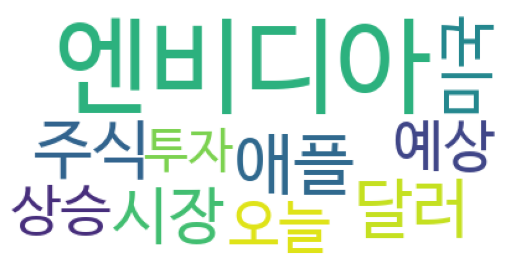

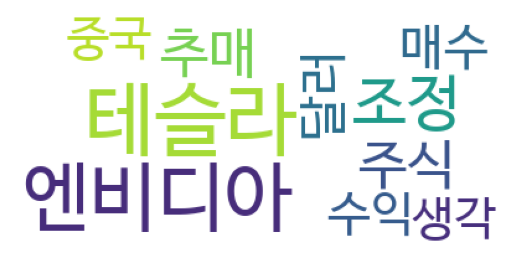

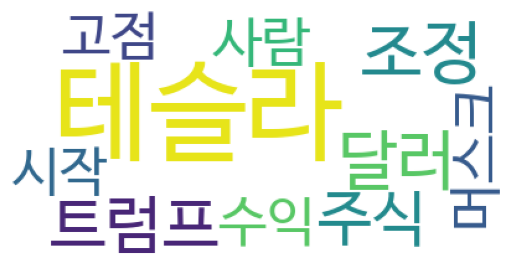

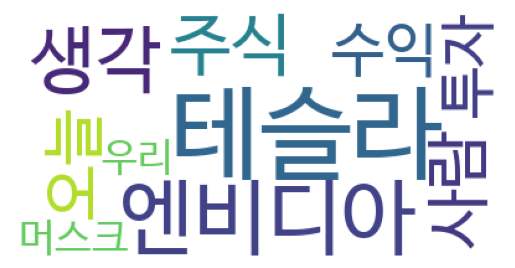

In [10]:
for text in weekly_data['COMMENT'].values:
    nouns_text = mecab_inst.nouns(text[:60000])
    filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]
    
    counter_text_splits = Counter(filtered_nouns)
    # 'ÏóîÎπÑ'ÏôÄ 'ÎπÑÎîîÏïÑ'Ïùò countÎ•º Ìï©Ï≥êÏÑú 'ÏóîÎπÑÎîîÏïÑ'Ïóê Ï†ÄÏû•
    if 'ÏóîÎπÑ' in counter_text_splits and 'ÎπÑÎîîÏïÑ' in counter_text_splits:
        combined_count = counter_text_splits['ÏóîÎπÑ'] + counter_text_splits['ÎπÑÎîîÏïÑ']
        counter_text_splits['ÏóîÎπÑÎîîÏïÑ'] = combined_count

        # 'ÏóîÎπÑ'ÏôÄ 'ÎπÑÎîîÏïÑ'Îäî Ïù¥Ï†ú ÏÇ≠Ï†ú (ÏÑ†ÌÉù ÏÇ¨Ìï≠)
        del counter_text_splits['ÏóîÎπÑ']
        del counter_text_splits['ÎπÑÎîîÏïÑ']

    counter_dict = dict(counter_text_splits.most_common()[:10])

    wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
    wordcloud_instance.generate_from_frequencies(counter_dict) 

    plt.imshow(wordcloud_instance)
    plt.axis('off')
    plt.show()


In [11]:
def run_wordcloud(date_col_name, comment_col_name):
    df_data['WEEK'] = df_data[date_col_name].apply(get_week)
    weekly_data = df_data.groupby(['WEEK']).agg({comment_col_name: ' '.join}).reset_index()
    print(weekly_data)

    for text in weekly_data[comment_col_name].values:
        nouns_text = mecab_inst.nouns(text[:60000])
        filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]

        counter_text_splits = Counter(filtered_nouns)
        # 'ÏóîÎπÑ'ÏôÄ 'ÎπÑÎîîÏïÑ'Ïùò countÎ•º Ìï©Ï≥êÏÑú 'ÏóîÎπÑÎîîÏïÑ'Ïóê Ï†ÄÏû•
        if 'ÏóîÎπÑ' in counter_text_splits and 'ÎπÑÎîîÏïÑ' in counter_text_splits:
            combined_count = counter_text_splits['ÏóîÎπÑ'] + counter_text_splits['ÎπÑÎîîÏïÑ']
            counter_text_splits['ÏóîÎπÑÎîîÏïÑ'] = combined_count

            # 'ÏóîÎπÑ'ÏôÄ 'ÎπÑÎîîÏïÑ'Îäî Ïù¥Ï†ú ÏÇ≠Ï†ú (ÏÑ†ÌÉù ÏÇ¨Ìï≠)
            del counter_text_splits['ÏóîÎπÑ']
            del counter_text_splits['ÎπÑÎîîÏïÑ']
        counter_dict = dict(counter_text_splits.most_common()[:10])

        wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
        wordcloud_instance.generate_from_frequencies(counter_dict) 

        plt.imshow(wordcloud_instance)
        plt.axis('off')
        plt.show()


   WEEK                                            COMMENT
0    47  Î®∏ÏÑ†ÏùºÏù¥Ïïº Î≠êÎÉê ÎÑà..Ïôú Ìù¨Îßù Í∞ñÍ≤åÌïòÎÉê Î™áÍ∞úÏõî Í∏∞Îã§Î¶¨Îã§Í∞Ä Ï°∞Í∏à Ïò¨ÎùºÏÑú Î∫èÎçîÎãà Ïûò Ïò¨...
1    49  Í≥ÑÏóÑ Ïã§Ìå® ÎÑàÎ¨¥ ÏïÑÏâ¨Ïö¥ ÏÇ¨Îûå Í∞úÏ∂î üëçüëçüëç 2024-12-04\n\nÏïàÎÖïÌïòÏÑ∏Ïöî Ï°¥Î≤ÑÍøÄ...
2    50  ÏπòÎß§ÏπòÎ£åÏïΩ Î¨∏Ïó¥Ïñ¥Ï£ºÏÑ∏Ïöî ÌòÑÍ∏∞Ï¶ùÎÇúÎã®ÎßêÏù¥ÏóêÏöî Ìïò.. 14Ìçº Ïò¨ÎûêÎäîÎç∞ 3ÎßåÏõêÎ∞ñÏóê Ïïà ÎÑ£Ïñ¥...
3    51  ÌÖåÏä¨Îùº Ìù•ÌñâÌïòÎ©¥ Íº≠ ÏûêÎπ†ÏßÄÎÑ§ Î∏åÎ°†Ï¶à Î±ÉÏßÄ„Ö£Îã® Îì£Î≥¥Îì§Ïù¥ Ï∞®Ìä∏Î∂ÑÏÑùÏùÑÏò¨Î¶∞Îã§?\nÍ∞ïÎ†•Ìïú Îß§...
4    52  Ïò§Îäò ÏßÑÏßú Í∂ÅÍ∏àÌïòÎÑ§ „Öã„Öã Ï†úÍ∞Ä Ïò¨Ìï¥ Ï¥ù 600 ÏàòÏùµÏùÑ ÎÉàÍ≥†\nÏßÄÍ∏à -330Ïù∏Îç∞ ÌåîÏïÑ...


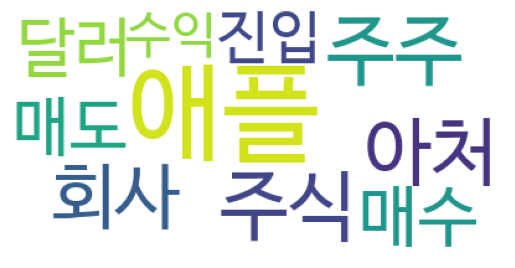

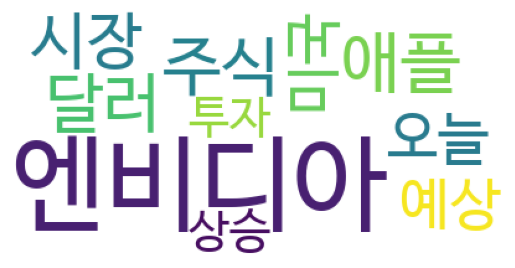

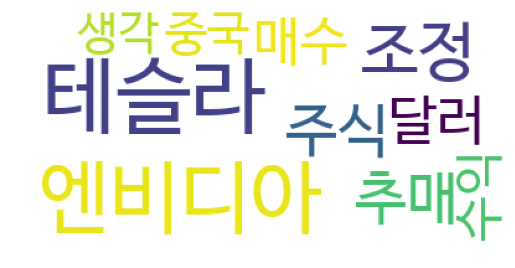

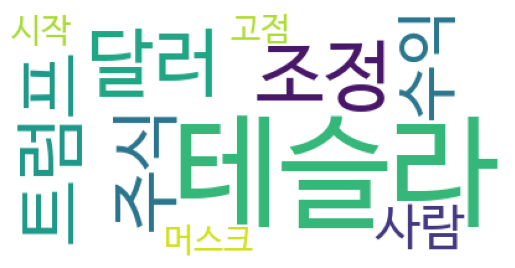

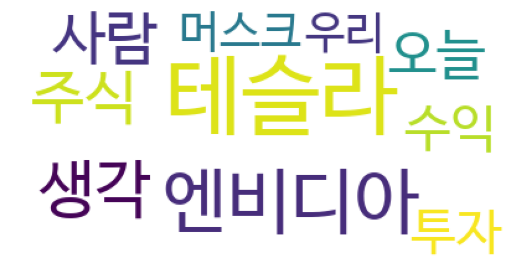

In [12]:
run_wordcloud('DATE','COMMENT')